In [85]:
#import sys
#sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [86]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [87]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [88]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, t_u, u, t_f, layers):
        
        # data
        self.t_u = torch.tensor(t_u, requires_grad=True).float().to(device)
        self.t_f = torch.tensor(t_f, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-10, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
        
    def net_u(self, t):  
        u = self.dnn(t)
        return u
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0]
                
        f = u_tt + 1/2 * u_t + u + 1/2 * torch.exp(-t/2)*torch.cos(t)
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.t_u)
        f_pred = self.net_f(self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, t):
        
        t = torch.tensor(t, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        u = self.net_u(t)
        f = self.net_f(t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [89]:
t = np.linspace(-1,1,100)
t = t.reshape(100,1)
N_f = 50
idx = np.random.choice(t.shape[0], N_f, replace=False)
t_f = t[idx]

t_u = np.array([0.0,1.0])
t_u = t_u.reshape(2,1)

u = np.array([0.0,np.exp(-1/2)*np.sin(1)])
u = u.reshape(2,1)

layers = [1, 5, 5, 5, 1]
model = PhysicsInformedNN(t_u, u, t_f, layers)

In [90]:
model.train()

Iter 100, Loss: 1.84333e-06, Loss_u: 6.66409e-08, Loss_f: 1.77669e-06
Iter 200, Loss: 4.12391e-07, Loss_u: 3.04638e-10, Loss_f: 4.12086e-07


In [91]:
u_pred, f_pred = model.predict(t) 

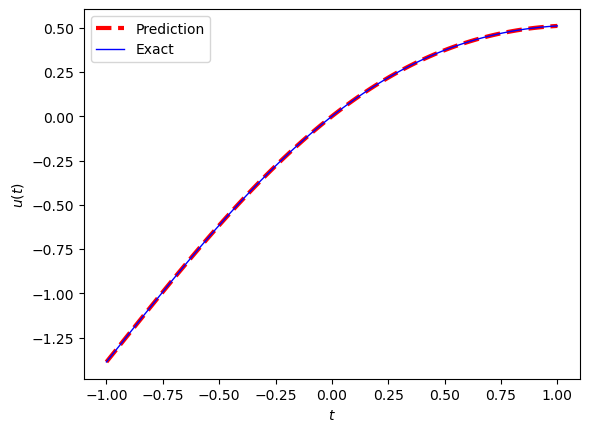

In [92]:
y = np.exp(-t/2) * np.sin(t)

fig,ax = plt.subplots()
ax.plot(t,u_pred,'r--',linewidth = 3, label='Prediction')
ax.plot(t,y,'b-', linewidth = 1, label = 'Exact')
ax.set_xlabel('$t$')
ax.set_ylabel('$u(t)$')
ax.legend()
plt.show()
